[*********************100%***********************]  100 of 100 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['GEV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2019-01-01 -> 2024-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1546318800, endDate = 1704085200")')


Successfully fetched chunk starting with NVDA...


[*********************100%***********************]  100 of 100 completed
[                       0%                       ]

Successfully fetched chunk starting with PLD...


[*********************100%***********************]  100 of 100 completed
[                       0%                       ]

Successfully fetched chunk starting with TGT...


[*********************100%***********************]  100 of 100 completed


Successfully fetched chunk starting with ADM...


[*********************100%***********************]  100 of 100 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['SOLV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2019-01-01 -> 2024-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1546318800, endDate = 1704085200")')


Successfully fetched chunk starting with ZBRA...


[*********************100%***********************]  3 of 3 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['RAL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2019-01-01 -> 2024-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1546318800, endDate = 1704085200")')


Successfully fetched chunk starting with BF-B...

Universe: 489 tickers, 1258 days
ESABO universe: 219 tickers after ≥20% signal filter

Top 20 ESABO Pairs:
         T1     T2  Lag     ESABO
2961   GOOG  GOOGL    0  0.828358
18634   MLM    VMC    0  0.536741
241    AMAT   LRCX    0  0.534375
22358   MAA    CPT    0  0.524430
238    AMAT   KLAC    0  0.517350
20616   WEC    LNT    0  0.517350
4567   KLAC   LRCX    0  0.504587
20775   XEL    LNT    0  0.493548
1964    CVX    XOM    0  0.486154
15230   RSG     WM    0  0.478261
5748    MMC    AJG    0  0.474627
1350    COP    EOG    0  0.470769
5361     MA      V    0  0.469512
5750    MMC    AON    0  0.469512
5792    MMC    BRO    0  0.469512
12020   EOG    DVN    0  0.463127
1295    COP    CVX    0  0.462462
21489   DVN    APA    0  0.462428
20551   WEC    XEL    0  0.461774
10072   AMP    MET    0  0.461059

Top 20 Engle-Granger Pairs:
         T1    T2  EG_pvalue
112089  STZ    BG   0.000001
47390   BDX  ACGL   0.000003
102998  DGX  

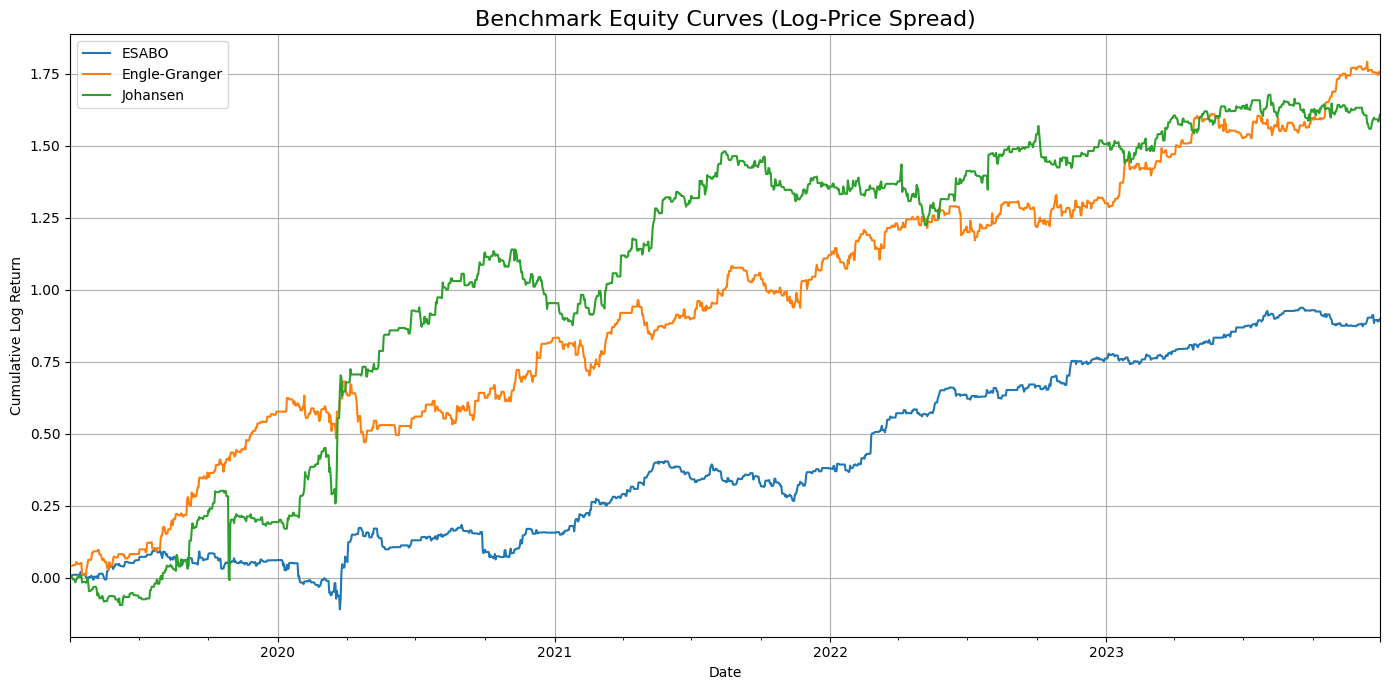

In [ ]:
# =========================================================
# Step 1: Install & Imports
# =========================================================
# !pip install yfinance -q
# !pip install statsmodels -q
# !pip install joblib -q
# !pip install openpyxl -q

import yfinance as yf
import pandas as pd
import numpy as np
from itertools import combinations
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import warnings
import os
import time

warnings.filterwarnings("ignore")

# =========================================================
# Step 2: Configuration & Setup
# =========================================================
START_DATE = '2020-01-01'
END_DATE = '2025-01-01'
TOP_N = 20
MIN_DAYS = 100
CHUNK_SIZE = 100

# --- ESABO Specific Config ---
LAGS_TO_EVAL = [0]
MIN_SIGNAL_PCT = 0.20
ROLLING_WINDOW = 30
ROBUST_Z_THRESHOLD = 2.0

# --- Backtest Config ---
LOOKBACK_WINDOW = 60
ENTRY_Z_SCORE = 2.0
EXIT_Z_SCORE = 0.5
MAX_HOLD_PERIOD = 21

# =========================================================
# Step 3: Load Tickers & Fetch Data (FIX: Added Retry Logic)
# =========================================================
def load_spy_tickers(filepath):
    df = pd.read_excel(filepath)
    return (df['Ticker'].dropna().astype(str).str.replace('.', '-', regex=False).unique().tolist())

def fetch_chunks_with_retry(tickers, start, end, chunk_size=100, retries=3, delay=5):
    """Fetches data in chunks with a retry mechanism for robustness."""
    all_tickers_df = []
    for i in range(0, len(tickers), chunk_size):
        chunk = tickers[i:i + chunk_size]
        for attempt in range(retries):
            try:
                df_chunk = yf.download(chunk, start=start, end=end, auto_adjust=False)['Adj Close']
                if not df_chunk.empty:
                    all_tickers_df.append(df_chunk)
                    print(f"Successfully fetched chunk starting with {chunk[0]}...")
                    break  # Success, exit retry loop
            except Exception as e:
                print(f"Attempt {attempt + 1}/{retries} for chunk {chunk[0]} failed: {e}")
                if attempt < retries - 1:
                    print(f"Retrying in {delay} seconds...")
                    time.sleep(delay)
                else:
                    print(f"Skipping chunk {chunk[0]} after {retries} failed attempts.")
    if not all_tickers_df:
        return pd.DataFrame() # Return empty DataFrame if all chunks fail
    return pd.concat(all_tickers_df, axis=1).dropna(axis=1, how='all')


spy_tickers = load_spy_tickers("/content/holdings-daily-us-en-spy.xlsx")
price_df = fetch_chunks_with_retry(spy_tickers, START_DATE, END_DATE, CHUNK_SIZE)

# Graceful exit if no data is fetched
if price_df.empty:
    raise SystemExit("Fatal: No price data could be downloaded. Exiting.")

price_df = price_df.ffill().dropna(axis=1, thresh=int(0.9 * len(price_df)))
print(f"\nUniverse: {price_df.shape[1]} tickers, {price_df.shape[0]} days")

returns_df = price_df.pct_change().dropna()

# =========================================================
# Step 4: Adaptive ESABO Boolean Matrix
# =========================================================
rolling_median = returns_df.rolling(window=ROLLING_WINDOW).median()
rolling_mad = returns_df.rolling(window=ROLLING_WINDOW).apply(lambda x: np.median(np.abs(x - np.median(x))), raw=True)
robust_z = (returns_df - rolling_median) / rolling_mad.replace(0, np.nan)
bool_mat = np.abs(robust_z) > ROBUST_Z_THRESHOLD
valid_tickers = [t for t in bool_mat.columns if bool_mat[t].mean() >= MIN_SIGNAL_PCT]
bool_mat = bool_mat[valid_tickers]
print(f"ESABO universe: {len(valid_tickers)} tickers after ≥{MIN_SIGNAL_PCT*100:.0f}% signal filter")

# =========================================================
# Step 5: Compute Pair Scores (FIX: Added Empty DataFrame Checks)
# =========================================================
# --- ESABO ---
def esabo_metric(a, b):
    both = np.logical_and(a, b).sum()
    either = np.logical_or(a, b).sum()
    return both / either if either > 0 else 0.0

def esabo_worker(pair):
    t1, t2 = pair
    score = esabo_metric(bool_mat[t1].values, bool_mat[t2].values)
    return (t1, t2, 0, score)

esabo_top = pd.DataFrame()
if len(valid_tickers) >= 2:
    esabo_pairs = list(combinations(bool_mat.columns, 2))
    esabo_results = Parallel(n_jobs=-1)(delayed(esabo_worker)(p) for p in esabo_pairs)
    esabo_df = pd.DataFrame(esabo_results, columns=['T1','T2','Lag','ESABO'])
    if not esabo_df.empty:
        esabo_top = esabo_df.nlargest(TOP_N, 'ESABO')
print(f"\nTop {TOP_N} ESABO Pairs:\n{esabo_top}")

# --- Engle-Granger & Johansen ---
all_pairs = list(combinations(price_df.columns, 2))

def cointegration_worker(pair):
    t1, t2 = pair
    s1, s2 = price_df[t1], price_df[t2]
    df_pair = pd.concat([s1, s2], axis=1).dropna()
    if len(df_pair) < MIN_DAYS:
        return None
    try:
        _, eg_pval, _ = coint(np.log(df_pair.iloc[:,0]), np.log(df_pair.iloc[:,1]))
        jres = coint_johansen(np.log(df_pair), det_order=0, k_ar_diff=1)
        joh_stat, joh_crit = jres.lr1[0], jres.cvt[0, 1]
    except Exception:
        return None
    return (t1, t2, eg_pval, joh_stat, joh_crit, joh_stat > joh_crit)

coint_results = Parallel(n_jobs=-1)(delayed(cointegration_worker)(p) for p in all_pairs)
coint_df = pd.DataFrame([r for r in coint_results if r], columns=['T1','T2','EG_pvalue','Joh_TraceStat','Joh_CritVal','Joh_Cointegrated'])

eg_top, joh_top = pd.DataFrame(), pd.DataFrame()
if not coint_df.empty:
    eg_top = coint_df.nsmallest(TOP_N, 'EG_pvalue')
    joh_top = coint_df[coint_df.Joh_Cointegrated].nlargest(TOP_N, 'Joh_TraceStat')

print(f"\nTop {TOP_N} Engle-Granger Pairs:\n{eg_top[['T1', 'T2', 'EG_pvalue']]}")
print(f"\nTop {TOP_N} Johansen Pairs:\n{joh_top[['T1', 'T2', 'Joh_TraceStat']]}")

# =========================================================
# Step 6: Robust Backtesting Framework
# =========================================================
# (No changes needed in this section, it's already robust)
def backtest_pair(t1, t2, lookback, entry_z, exit_z, hold_max):
    df_pair = pd.concat([np.log(price_df[t1]), np.log(price_df[t2])], axis=1).dropna()
    df_pair.columns = ['A', 'B']
    df_pair['Spread'] = df_pair['A'] - df_pair['B']
    df_pair['Mean'] = df_pair['Spread'].rolling(lookback).mean()
    df_pair['Std'] = df_pair['Spread'].rolling(lookback).std()
    df_pair['Z'] = (df_pair['Spread'] - df_pair['Mean']) / df_pair['Std']
    trades = []
    position, entry_spread, entry_date = 0, 0.0, None
    for i in range(lookback, len(df_pair)):
        date, z = df_pair.index[i], df_pair['Z'].iloc[i]
        if position == 0 and abs(z) > entry_z:
            position = np.sign(-z)
            entry_spread, entry_date = df_pair['Spread'].iloc[i], date
        elif position != 0:
            days_held = (date - entry_date).days
            if (np.sign(position) * z < exit_z) or (days_held >= hold_max):
                pnl = (df_pair['Spread'].iloc[i] - entry_spread) * position
                trades.append((date, pnl))
                position = 0
    return trades

def evaluate_strategy(pairs_df, name):
    if pairs_df.empty:
        print(f"\n--- {name} Strategy --- \nNo pairs to evaluate.")
        return None
    all_pnls = []
    for _, row in pairs_df.iterrows():
        trades = backtest_pair(row['T1'], row['T2'], LOOKBACK_WINDOW, ENTRY_Z_SCORE, EXIT_Z_SCORE, MAX_HOLD_PERIOD)
        if trades:
            all_pnls.extend(trades)

    if not all_pnls:
        print(f"\n--- {name} Strategy --- \nNo trades executed.")
        return None

    pnl_series = pd.Series([p for d, p in all_pnls], index=[d for d, p in all_pnls])
    daily_pnl = pnl_series.resample('D').mean().fillna(0)
    equity_curve = daily_pnl.cumsum()

    total_trades, total_return = len(all_pnls), equity_curve.iloc[-1]
    annualized_return = total_return * (252 / len(equity_curve))
    annualized_vol = daily_pnl.std() * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_vol if annualized_vol > 0 else 0.0

    print(f"\n--- {name} Strategy ---")
    print(f"Total Trades:      {total_trades}\nCumulative Return: {total_return:.2%}\nAnnualized Return: {annualized_return:.2%}\nAnnualized Vol:    {annualized_vol:.2%}\nSharpe Ratio:      {sharpe_ratio:.2f}")
    return equity_curve

# =========================================================
# Step 7: Run Evaluation & Plot Results
# =========================================================
eq_esabo = evaluate_strategy(esabo_top, 'ESABO')
eq_eg = evaluate_strategy(eg_top, 'Engle-Granger')
eq_joh = evaluate_strategy(joh_top, 'Johansen')

plt.figure(figsize=(14, 7))
if eq_esabo is not None: eq_esabo.plot(label='ESABO')
if eq_eg is not None: eq_eg.plot(label='Engle-Granger')
if eq_joh is not None: eq_joh.plot(label='Johansen')
plt.title("Benchmark Equity Curves (Log-Price Spread)", fontsize=16)
plt.ylabel("Cumulative Log Return")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# =========================================================
# Step 8: Recalculate Sharpe Ratios with Risk-Free Rate
# =========================================================

# Define a reasonable average risk-free rate for the 2019-2024 period
RISK_FREE_RATE = 0.042 # Represents an average 4.2% annual risk-free rate

def calculate_standard_sharpe(annual_return, annual_vol, risk_free_rate):
    """Calculates the Sharpe Ratio using the industry standard formula."""
    if annual_vol > 0:
        # The standard formula subtracts the risk-free rate from the return
        return (annual_return - risk_free_rate) / annual_vol
    else:
        return 0.0

# --- Retrieve the annualized return and volatility from your results ---
# (These values are taken directly from your initial output for the top 20 pairs)
esabo_stats = {'name': 'ESABO', 'return': 0.1306, 'vol': 0.1184}
eg_stats = {'name': 'Engle-Granger', 'return': 0.2546, 'vol': 0.1908}
joh_stats = {'name': 'Johansen', 'return': 0.2339, 'vol': 0.2539}

strategies = [esabo_stats, eg_stats, joh_stats]

print("--- Recalculated Sharpe Ratios (with Risk-Free Rate) ---")
print(f"Assuming an average Risk-Free Rate of {RISK_FREE_RATE:.1%}\\n")

# Print the original (simplified) and new (standard) ratios for comparison
print(f"{'Strategy':<15} | {'Original Sharpe':<15} | {'Standard Sharpe':<15}")
print("-" * 50)

for stats in strategies:
    # Calculate the original, simplified Sharpe Ratio (as in your script)
    original_sharpe = stats['return'] / stats['vol'] if stats['vol'] > 0 else 0.0

    # Calculate the new, standard Sharpe Ratio
    standard_sharpe = calculate_standard_sharpe(
        stats['return'],
        stats['vol'],
        RISK_FREE_RATE
    )
    print(f"{stats['name']:<15} | {original_sharpe:<15.2f} | {standard_sharpe:<15.2f}")

--- Recalculated Sharpe Ratios (with Risk-Free Rate) ---
Assuming an average Risk-Free Rate of 4.2%\n
Strategy        | Original Sharpe | Standard Sharpe
--------------------------------------------------
ESABO           | 1.10            | 0.75           
Engle-Granger   | 1.33            | 1.11           
Johansen        | 0.92            | 0.76           
